In [1]:
import sys
import getpass
sys.path.append("../scripts/")

import pandas as pd
import numpy as np
import helper_functions as hf
import seaborn as sns

pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

In [2]:
user = getpass.getuser()

---

## Data

In [3]:
if user == "preston":
    datapath = "../../project/data/monet_output.csv"
else:
    datapath = "../../monet_output.csv"
    
data = pd.read_csv(datapath)

C:\Users\preston\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (10,17,19,23,25,27,28,29,30,32,33,36,37,38,39,40,41,42,43,50,51,83,86,89,92,94,95,97,100,103,106,110,113,116,121,124,127,130,133,136,188,190,201,212,231,232,242,244,247,249,256,262,267,273,279,280,281,282,283,284,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,305,318,320,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


---

## Clean Data

In [4]:
dropcols = ['Unnamed: 0', 'X'] + \
['ETOH',
'CPNEUMON',
'DNR',
'ESOVAR',
'HXMI',
'PRVPCI',
'PRVPCS',
'HXANGINA',
'HXPVD',
'RESTPAIN',
'IMPSENS',
'COMA',
'HEMI',
'HXTIA',
'CVA', 
'CVANO', 
'TUMORCNS', 
'QUAD', 
'CHEMO', 
'RADIO', 
'CNSCOMA', 
'NEURODEF', 
'OTHGRAFL', 
'PARA', 
'PREGNANCY']

In [5]:
## Drop extraneous columns
data.drop(dropcols, axis = 1, inplace = True)

In [6]:
## Replace -99 values with NA (int/float columns)
df_clean = data.replace(to_replace = -99, value = np.nan)

# num_cols = data.columns[(data.dtypes == "int64") | (data.dtypes == "float")]
# df_clean = hf.set_nulls(data, num_cols)

In [7]:
#### For these mappings, we might want to have a simple file with the associated values
   # rather than having to have these larger chunks of text
   # Also, COL_APPROACH can probably be a binary feature instead

## Map PRNCPTX to numeric values
op1 = ['COLCT TOT ABDL W/O PRCTECT W/CONTINENT ILEOST']
op2 = ['COLCT TOT ABDL W/O PRCTECT W/ILEOST/ILEOPXTS', 'LAPS COLECTOMY TOT W/O PRCTECT W/ILEOST/ILEOPXTS']
op3 = ['COLECTOMY PARTIAL W/ANASTOMOSIS', 'LAPAROSCOPY COLECTOMY PARTIAL W/ANASTOMOSIS']
op4 = ['COLECTOMY PRTL ABDOMINAL & TRANSANAL APPROACH', 'COLECTOMY PRTL ABDOMINAL & TRANSANAL APPR']
op5 = ['COLECTOMY PRTL W/COLOPROCTOSTOMY', 'LAPS COLECTOMY PRTL W/COLOPXTSTMY LW ANAST']
op6 = ['COLECTOMY PRTL W/COLOPROCTOSTOMY & COLOSTOMY', 'LAPS COLECTMY PRTL W/COLOPXTSTMY LW ANAST W/CLST']
op7 = ['COLECTOMY PRTL W/COLOST/ILEOST & MUCOFISTULA']
op8 = ['COLECTOMY PRTL W/END COLOSTOMY & CLSR DSTL SGMT', 'COLECTOMY PRTL W/END COLOSTOMY&CLSR DSTL SGMT', 'LAPS COLECTOMY PRTL W/END CLST & CLSR DSTL SGM', 'LAPS COLECTOMY PRTL W/END CLST&CLSR DSTL SGM']
op9 = ['COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS', 'COLECTOMY PRTL W/RMVL TERMINAL ILEUM&ILEOCOLOST', 'LAPS COLECTOMY PRTL W/RMVL TERMINAL ILEUM', 'COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOST']
op10 = ['COLECTOMY PRTL W/SKIN LEVEL CECOST/COLOSTOMY']
num_replacements = [op1, op2, op3, op4, op5, op6, op7, op8, op9, op10]
for i in range(len(num_replacements)):
    df_clean = hf.map_cpt(df_clean, 'PRNCPTX', num_replacements[i], i+1)

## Map COL_APPROACH to "open"/"open (planned)"
MIS = ['Laparoscopic', 'Endoscopic w/ unplanned conversion to open', 'Hybrid', 'Hybrid w/ open assist', 'Laparoscopic Hand Assisted', 'Laparoscopic w/ open assist', 'Laparoscopic w/ unplanned conversion to open', 'Laparoscopic w/ unplanned conversion to Open', 'Other MIS approach', 'Robotic', 'Robotic w/ open assist', 'Robotic w/ unplanned conversion to open', 'SILS', 'SILS w/ open assist', 'SILS w/ unplanned conversion to open', 'Hybrid w/ unplanned conversion to open', 'Endoscopic w/ open assist', 'Other MIS approach w/ open assist', 'Endoscopic', 'NOTES', 'NOTES w/ open assist', 'Other MIS approach w/ unplanned conversion to open', 'NOTES w/ unplanned conversion to open']
Open = ['Open', 'Open (planned)']
options = [MIS, Open]
names = ['MIS', 'open']
for i in range(len(options)):
    df_clean = hf.map_cpt(df_clean, 'COL_APPROACH', options[i], names[i])
    
df_clean.COL_APPROACH.replace("Unknown", np.nan, inplace = True)

C:\Users\preston\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


---

## Target

In [8]:
unplanned = [c for c in df_clean if "UNPLANNEDREADMISSION" in c]
df_clean['num_unplanned'] = df_clean[unplanned].sum(axis=1)

df_clean['target'] = [1 if x>0 else 0 for x in df_clean['num_unplanned']]

---

## Build-a-Heatmap Workshop

In [9]:
## Drop features with names including ___
 # - Should probably be updated to be less general--we should drop "columns like ___"
todrop = df_clean.columns[(df_clean.dtypes == "object").values].to_list()
dropstr = ["CASEID", "DPR", "PR", "OTHER", "CON", "DT", "YR", "YEAR", "COL_", "READM", "RETOR", "REOP"]

for string in dropstr:
    todrop = todrop + [c for c in df_clean if string in c]

In [10]:
df_num = df_clean.drop(todrop, axis = 1)

In [11]:
df_num

,CPT,WORKRVU,HEIGHT,WEIGHT,SMOKE,PACKS,VENTILAT,HXCOPD,ASCITES,HXCHF,HYPERMED,RENAFAIL,DIALYSIS,DISCANCR,WNDINF,STEROID,WTLOSS,BLEEDDIS,TRANSFUS,PGY,EMERGNCY,ANESURG,SURGANE,DPATRM,ANETIME,OPTIME,TOTHLOS,NSUPINFEC,SUPINFEC,DSUPINFEC,NWNDINFD,WNDINFD,DWNDINFD,NORGSPCSSI,ORGSPCSSI,DORGSPCSSI,NDEHIS,DEHIS,DDEHIS,NOUPNEUMO,OUPNEUMO,DOUPNEUMO,NREINTUB,REINTUB,DREINTUB,NPULEMBOL,PULEMBOL,DPULEMBOL,NFAILWEAN,FAILWEAN,DFAILWEAN,NRENAINSF,RENAINSF,DRENAINSF,NURNINFEC,URNINFEC,DURNINFEC,NCNSCVA,CNSCVA,DCNSCVA,NCNSCOMA,NNEURODEF,NCDARREST,CDARREST,DCDARREST,NCDMI,CDMI,DCDMI,NOTHBLEED,OTHBLEED,DOTHBLEED,NOTHGRAFL,NOTHDVT,OTHDVT,DOTHDVT,NOTHSYSEP,OTHSYSEP,DOTHSYSEP,NOTHSESHOCK,OTHSESHOCK,DOTHSESHOCK,PODIAG,RETURNOR,ETHNICITY_HISPANIC,ELECTSURG,STILLINHOSP,SSSIPATOS,DSSIPATOS,OSSIPATOS,PNAPATOS,UTIPATOS,VENTPATOS,AGE,ADMQTR,HTOODAY,DOPERTOD,DOPTODIS,SEPSISPATOS,SEPSHOCKPATOS,BLEEDIS,OTHCDIFF,NOTHCDIFF,DOTHCDIFF,num_unplanned,target
0,44146,35.30,67.0,165.0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0.0,0,NaN,0,NaN,NaN,NaN,NaN,206.0,4.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0.0,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0,0,NaN,0,0,NaN,0,0,NaN,154.1,0,0.0,1.0,0,0,0,0,0,0,0,43.0,1,0.0,NaN,4.0,0,0,NaN,NaN,NaN,NaN,0.0,0
1,44150,30.18,69.0,216.0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0.0,0,NaN,0,NaN,NaN,NaN,NaN,213.0,12.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0.0,0,0,NaN,0,0,NaN,1,1,1.0,0.0,0,0,NaN,0,0,NaN,0,0,NaN,555.1,0,0.0,0.0,0,0,0,0,0,0,0,40.0,4,4.0,NaN,8.0,0,0,NaN,NaN,NaN,NaN,0.0,0
2,44205,22.95,63.0,205.0,0,NaN,0,0,0,0,1,0,0,0,0,1,0,0.0,0,NaN,0,NaN,NaN,NaN,NaN,80.0,1.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0.0,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0,0,NaN,0,0,NaN,0,0,NaN,211.3,0,0.0,1.0,0,0,0,0,0,0,0,63.0,1,0.0,NaN,1.0,0,0,NaN,NaN,NaN,NaN,0.0,0
3,44207,31.92,67.0,125.0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0.0,0,NaN,0,NaN,NaN,NaN,NaN,0.0,17.0,0,0,NaN,1,1,6.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0.0,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0,0,NaN,0,0,NaN,0,0,NaN,154.0,1,0.0,1.0,0,0,0,0,0,0,0,53.0,1,0.0,NaN,17.0,0,0,NaN,NaN,NaN,NaN,0.0,0
4,44204,26.42,63.0,159.0,1,NaN,0,0,0,0,1,0,0,0,0,0,0,0.0,0,NaN,0,NaN,NaN,NaN,NaN,316.0,4.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0.0,0,0,NaN,0,0,NaN,0,0,NaN,0.0,0,0,NaN,0,0,NaN,0,0,NaN,562.1,0,0.0,1.0,0,0,0,0,0,0,0,62.0,1,0.0,NaN,4.0,0,0,NaN,NaN,NaN,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257908,44207,31.92,63.0,150.0,0,NaN,0,0,0,0,0,0,0,1,0,0,1,NaN,0,NaN,0,NaN,NaN,NaN,NaN,281.0,4.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,0,0.0,1.0,0,0,0,0,0,0,0,59.0,4,0.0,NaN,4.0,0,0,0.0,0.0,0.0,NaN,1.0,1
257909,44204,26.42,64.0,130.0,0,NaN,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,224.0,2.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,0,0.0,1.0,0,0,0,0,0,0,0,55.0,4,0.0,NaN,2.0,0,0,0.0,0.0,0.0,NaN,0.0,0
257910,44207,31.92,70.0,215.0,0,NaN,0,0,0,0,1,0,0,0,0,0,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,340.0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,NaN,0,0,NaN,NaN,1,0.0,1.0,1,0,0,0,0,0,0,77.0,4,0.0,NaN,NaN,0,0,0.0,0.0,0.0,NaN,0.0,0
257911,44207,31.92,67.0,185.0,0,NaN,0,0,0,0,1,0,0,0,0,0,0,NaN,0,NaN,0,NaN,NaN,NaN,NaN,141.0,7.0,0,0,NaN,0,0,NaN,0,0,NaN,0,0

In [12]:
## Find and plot large correlations
correlations = df_num.corr()
perc = correlations.abs().describe()
df_corr = df_num[perc.columns[(perc.loc["75%"] >= 0.15).values].to_list() + ["target"]].corr()

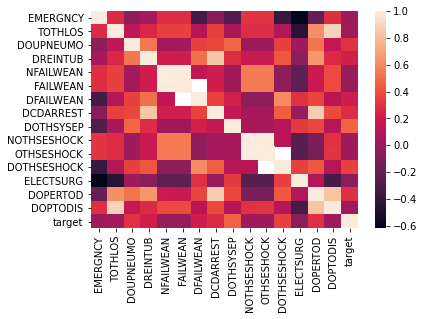

In [15]:
sns.heatmap(df_corr)

In [17]:
target_corr = df_clean.corr()['target'].sort_values()

In [26]:
target_corr

CONWRVU9                  -0.293757
READMPODAYS1              -0.100918
CONCPT6                   -0.089823
PGY                       -0.073640
PROPER30                  -0.066864
CPT                       -0.061003
CONCPT4                   -0.057402
PRHCT                     -0.053210
CONCPT7                   -0.052034
PRALBUM                   -0.051198
ELECTSURG                 -0.049540
OTHERWRVU6                -0.047971
ANETIME                   -0.041343
STILLINHOSP               -0.037415
PACKS                     -0.036427
READMPODAYS2              -0.036107
COL_ORAL_ANTIBIOTIC       -0.031499
COL_MECH_BOWEL_PREP       -0.030748
PRSODM                    -0.028506
DPRHCT                    -0.026726
DPRCREAT                  -0.026619
DPRNA                     -0.026571
DPRBUN                    -0.026010
DPRWBC                    -0.025864
DPRPLATE                  -0.025793
CONCPT5                   -0.022997
DPRALKPH                  -0.021358
ANESURG                   -0